# Commercial Bank Customer Retention Prediction

## APSTA-GE.2401: Statistical Consulting

## Scripts

Created on: 12/07/2020

Modified on: 12/28/2020

## Supervised Learning Models

----

### Description

This script contains the machine learning models.

### Research Design

The strategy of supervised learning is to train models using the `X_train` data and validate model performance using the `y_train` data. After training, we fit the model to the `X_test` data. The model will then generate predictions, `y_test`, based on `X_test`. 

To increase model performance, we splited the train set into two sets: 80% of the train data goes to the `X_train` set and 20% of the data goes to the `X_test` set. Then, we conducted a 5-fold cross validation and selected the best performed model output. We also find tuned hyperparameters using randomized search.

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import TruncatedSVD
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

print('SUCCESS! All modules are imported.')

SUCCESS! All modules are imported.


----

In [227]:
X = pd.read_csv('../data/X_train.csv')
y = pd.read_csv('../data/y_train.csv')
X_hold = pd.read_csv('../data/X_test.csv')

In [228]:
print('The model-ready training set has {} rows and {} columns.'.format(X.shape[0], X.shape[1]))
print('The model-ready validation set has {} rows and {} columns.'.format(y.shape[0], y.shape[1]))
print('The model-ready testing set has {} rows and {} columns.'.format(X_hold.shape[0], X_hold.shape[1]))

The model-ready training set has 145296 rows and 78 columns.
The model-ready validation set has 145296 rows and 2 columns.
The model-ready testing set has 76722 rows and 78 columns.


In [229]:
ID_y = y.drop('cust_no', axis=1)

In [230]:
X['label'] = ID_y

In [231]:
X['label'].value_counts()

 1    92818
 0    30237
-1    22241
Name: label, dtype: int64

In [232]:
X_1 = X[X['label'] == 1]

In [233]:
X = X[X['label'] != 1]

In [234]:
X_1_down = X_1.sample(frac=len(X_1)/145296, replace=True, random_state=1061)

In [235]:
X = X.append(X_1_down)

In [236]:
X['label'].value_counts()

 1    59294
 0    30237
-1    22241
Name: label, dtype: int64

In [237]:
y = X['label']

In [238]:
X = X.drop('label', axis=1)

In [239]:
y = label_binarize(y, classes=[-1, 0, 1])

In [240]:
n_classes = y.shape[1]

### Train Test Split

In [241]:
X = X.drop('cust_no', axis=1)

In [242]:
ID_hold = X_hold['cust_no']
X_hold = X_hold.drop('cust_no', axis=1)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1061)

In [244]:
print('After train test split, the training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('After train test split, the train has {} labels.'.format(y_train.shape[0]))
print('After train test split, the test set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('After train test split, the test has {} labels.'.format(y_test.shape[0]))

After train test split, the training set has 89417 rows and 77 columns.
After train test split, the train has 89417 labels.
After train test split, the test set has 22355 rows and 77 columns.
After train test split, the test has 22355 labels.


----

## Feature Importance Analysis

### SVD

In [245]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [246]:
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
scaled_X_hold = pd.DataFrame(scaler.transform(X_hold), columns = X_hold.columns)

In [247]:
s = np.linalg.svd(scaled_X_train, compute_uv=False)

In [248]:
np.cumsum(s**2)/np.sum(s**2)

array([0.09100192, 0.14402396, 0.19059882, 0.2342622 , 0.27206094,
       0.30781718, 0.33786642, 0.36530245, 0.389161  , 0.41147286,
       0.4321681 , 0.45071372, 0.46833202, 0.48517541, 0.50123088,
       0.51687757, 0.53230775, 0.54726429, 0.56178024, 0.57615499,
       0.59017157, 0.60415975, 0.61802223, 0.63167188, 0.64522724,
       0.65865493, 0.67200664, 0.6853029 , 0.69856962, 0.71161259,
       0.72447734, 0.73720582, 0.74989041, 0.76236483, 0.77455016,
       0.78654063, 0.79818168, 0.80961103, 0.82073197, 0.83169811,
       0.84223335, 0.85252623, 0.86248706, 0.87226481, 0.88153697,
       0.89026988, 0.89886328, 0.90710684, 0.91523509, 0.92297293,
       0.93033161, 0.93743615, 0.94416881, 0.950458  , 0.95660398,
       0.96226857, 0.96752301, 0.9724089 , 0.97708458, 0.98158335,
       0.98555778, 0.9893904 , 0.99278714, 0.99534579, 0.99763728,
       0.99943035, 0.99996281, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

#### SVD Results

SVD results indicate that the number of components to retain 80% of information is 37.

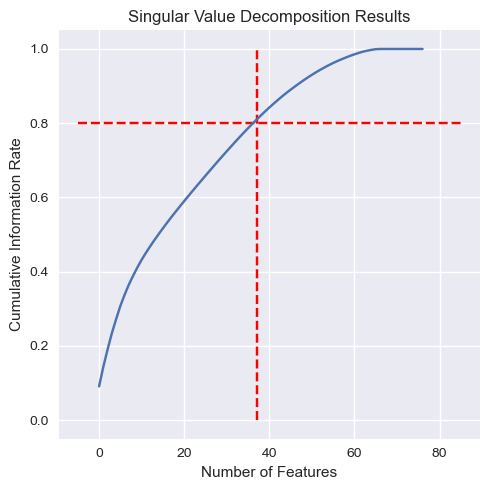

In [249]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=100, tight_layout=True)
plt.plot(np.cumsum(s**2)/np.sum(s**2))
plt.hlines(y=0.8, xmin=-5, xmax=85, linestyles='dashed', colors='red')
plt.vlines(x=37, ymin=0, ymax=1.0, linestyles='dashed', colors='red')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Information Rate')
plt.title('Singular Value Decomposition Results')
plt.show()
fig.savefig('../results/svd.png', dpi=fig.dpi)

In [250]:
svd = TruncatedSVD(n_components=37)
svd.fit(scaled_X_train)

TruncatedSVD(algorithm='randomized', n_components=37, n_iter=5,
             random_state=None, tol=0.0)

In [251]:
best_features = [scaled_X_train.columns[col] for col in svd.components_[0].argsort()[: : -1][:15]]

In [252]:
best_features

['3',
 'C2',
 '12',
 '1',
 'B1',
 'I6',
 'B2',
 '2',
 'C1',
 'X1',
 'B7',
 'B4',
 'X4',
 'E18_d',
 'I1']

In [253]:
best_feature_names = ['Gold', '# of Products', 'Age', 'Platinum', '# of mobile Bank Login',
                 'is_Loan', '# of transfer-in', 'Diamond', 'Assets Amount', 'Structural Savings',
                 '# of Seasonal Transfers', '# of transfer-out', 'End of Month CD Amount,', 'Date of Biggest Transfer-in', 'Gender']

In [254]:
best_features_explained_variance = svd.explained_variance_

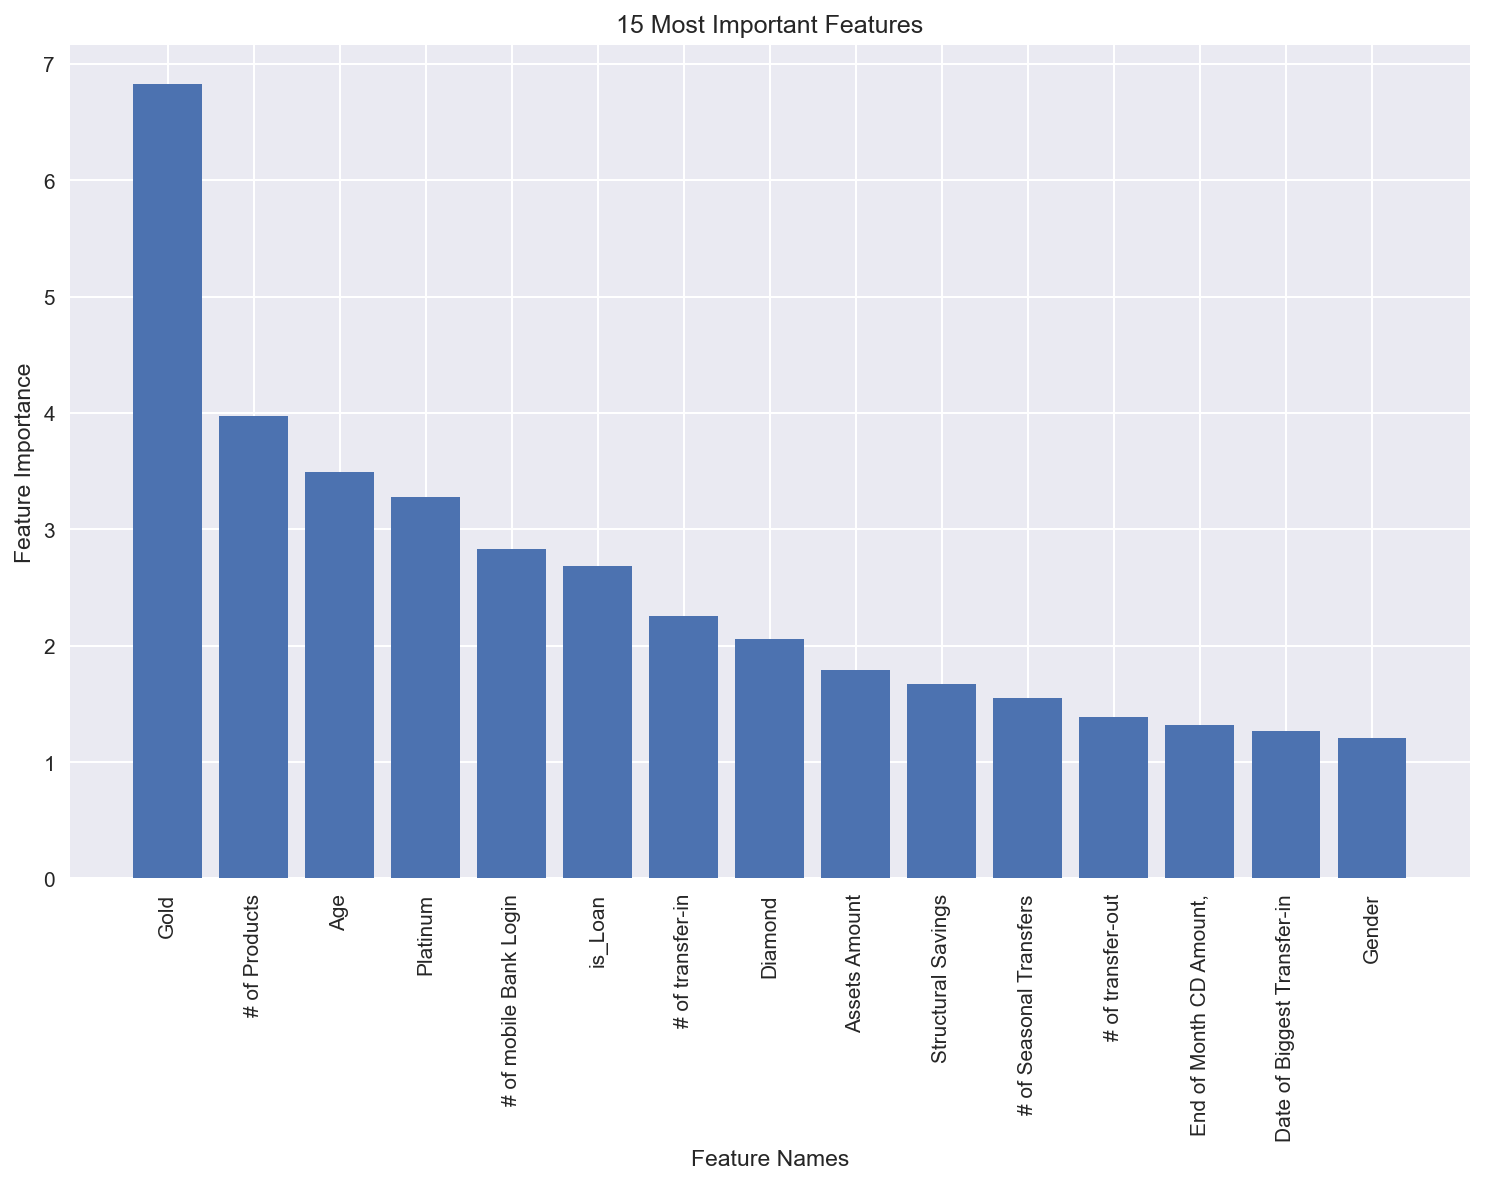

In [255]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(10, 8), dpi=150, tight_layout=True)
plt.bar(best_feature_names, height=best_features_explained_variance[0:15])
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('15 Most Important Features')
plt.show()
fig.savefig('../results/feature_importance.png', dpi=fig.dpi)

In [256]:
X_train_svd = X_train[best_features]
X_test_svd = X_test[best_features]
scaled_X_train_svd = scaled_X_train[best_features]
scaled_X_test_svd = scaled_X_test[best_features]

In [257]:
X_hold_svd = X_hold[best_features]
scaled_X_hold_svd = scaled_X_hold[best_features]

In [259]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

----

### Logistic Regression (SVD)

In [330]:
logreg = LogisticRegressionCV(max_iter=5000, random_state=1061, cv=5, verbose=0.1)

In [331]:
ovr = OneVsRestClassifier(logreg)

In [332]:
ovr.fit(scaled_X_train_svd, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                   cv=5, dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None,
                                                   max_iter=5000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=1061,
                                                   refit=True, scoring=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0.1),
                    n_jobs=None)

In [333]:
y_score = ovr.decision_function(scaled_X_test_svd)

In [334]:
y_score

array([[-2.22643921, -0.96997986,  0.41699172],
       [-2.74962113, -0.970242  ,  0.56624498],
       [-1.28899947, -0.94074664,  0.12550556],
       ...,
       [-1.72407978, -0.94986751,  0.18737822],
       [-1.79704379, -0.95968592,  0.33390707],
       [-2.8685166 , -1.05452383,  0.65184264]])

In [335]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [336]:
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [337]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [338]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

/Users/Jinink/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [339]:
mean_tpr /= n_classes

In [340]:
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

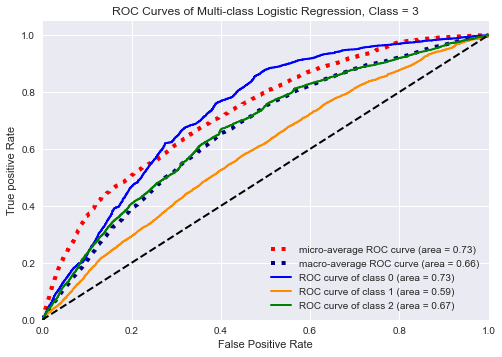

In [341]:
# Plot Logreg
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['micro']),
         color='red', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'darkorange', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC Curves of Multi-class Logistic Regression, Class = 3')
plt.legend(loc='lower right')
plt.savefig('../results/logreg.png', dpi=150)
plt.show()

----

### Random Forest

In [346]:
rf = RandomForestClassifier(criterion='entropy', random_state=1061, verbose=0.1)

In [347]:
ovr = OneVsRestClassifier(rf)
ovr.fit(scaled_X_train_svd, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                         

In [348]:
y_score = ovr.predict_proba(scaled_X_test_svd)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
/Users/Jinink/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


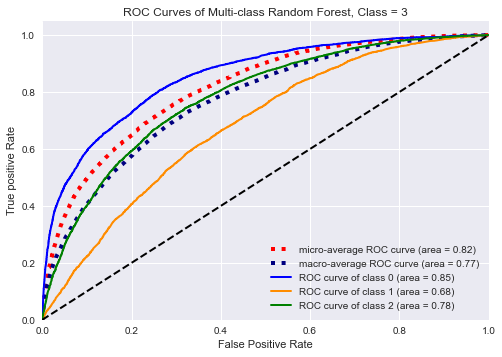

In [353]:
# Plot RF
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['micro']),
         color='red', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'darkorange', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC Curves of Multi-class Random Forest, Class = 3')
plt.legend(loc='lower right')
plt.savefig('../results/rf.png', dpi=150)
plt.show()

----

### Gradient Boosting Machine

In [350]:
gb = GradientBoostingClassifier()
ovr = OneVsRestClassifier(gb)
ovr.fit(scaled_X_train_svd, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=

In [351]:
y_score = ovr.predict_proba(scaled_X_test_svd)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

/Users/Jinink/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


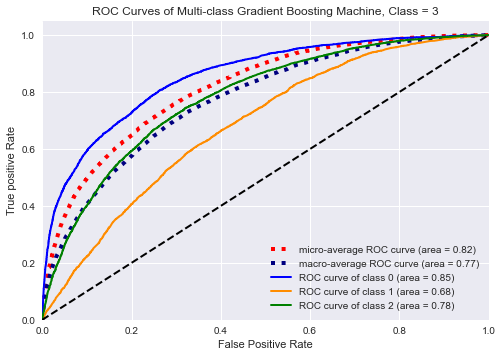

In [354]:
# Plot GBM
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['micro']),
         color='red', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'darkorange', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label='ROC curve of class {0} (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC Curves of Multi-class Gradient Boosting Machine, Class = 3')
plt.legend(loc='lower right')
plt.savefig('../results/gbm.png', dpi=150)
plt.show()

----